<center>

# Transient Analysis and Steady State Dynamic Solver

## Name : ANIRUDH B S
## Roll No : EE21B019
</center>

## Involved Idea 
To simulate transients is not easy as described in class. However, I have approached this problem of simulating transients using the s-domain approach using sympy and scipy.signal. Using these powerful libraries of python, I shall convert a given circuit in time domain to s-domain, solve it and retrieve the time-domain transient response of the given circuit. This idea looks novice, but works for any arbitrary networks of R, L and C with independent voltage and current source. The initial conditions of capacitor and inductor have also been accounted for and it is also considered that all sources DC or AC are switched on at t=0 and transients thus obtained are being analysed.

### Difference between this and Assignment 2
The additional functionalities of this notebook over Assignment 2 are described below 
- This code works dynamically, that is instantaneous change in parameters of the circuit will result in the output automatically changing itself as per the changes
- The Assignment 2 had no relation to plotting graphs. This code plots the graphs corresponding to various potentials and currents in the circuit with time.
- This notebook has interactability, the user can interact with the code using widgets which was not offered in Assignment 2.
- This notebook draws the circuit diagram which otherwise was not done in Assignment 2
- The functionality of Bode Plot has also been added using which the user can find out at what frequency maxiumum gain is obtained which was not available in Assignment 2.

## Additional Requirements in the Netlist 
The code needs some additional requirements to draw the circuit beautifully using LCAPY. It is assumed that the input netlist also specifies where the elements need to be placed. 

For example,

R1 n1 n2 R ; down 

implies that Resistor R1 of value R is placed between n1 and n2 and **n2 is below n1**.

- Four instructions are permitted in the above format : up, down, right, left
- Label the nodes properly and ensure that the circuit diagram is closed properly. DO NOT add random wires, this has not been handled. Add only R, L, C, V and I elements, for any other element, this code will fail.

# Dynamic Steady State Solver

### This code segment allows us to change values dynamically and display the steady state complex values.

In [1]:
import numpy as np
import lcapy
from sympy import *

In [2]:
import numpy as np
import ipywidgets as wdg
import sys
import cmath

In [3]:
import scipy.signal as sp
import matplotlib.pyplot as plt

In [4]:
s = symbols('s')

### Assumption : The above mentioned packages are installed.
It is assumed that all the above packages are installed. If not, please do a pip install of the above packages as all of them have been used in respective places. 

The use of sympy and scipy.signal is to implement the s domain solving of circuit equations

The use of lcapy is to draw the circuit as input by the user.

In [5]:
class R: #Defined a class for resistor element to store it nicely
    value = 0
    nodes = ()
    def __init__(self, n1, n2, value) :
        self.value = value
        self.nodes = (n1, n2)

In [6]:
class C : #Defined a class for capacitor element to store it nicely
    value = 0
    nodes = ()
    charge = 0
    def __init__(self,  n1, n2, value, charge = 0) :
        self.value = value
        self.nodes = (n1, n2)
        self.charge = charge

In [7]:
class L : #Defined a class for inductor element to store it nicely
    value = 0
    nodes = ()
    current = 0
    def __init__(self, n1, n2, value, current =0) :
        self.value = value
        self.nodes = (n1, n2)
        self.current = current

In [8]:
class V : #Defined a class for voltage source element to store it nicely
    value = 0
    nodes= ()
    def __init__(self,  n1, n2, value) :
        self.value = value
        self.nodes = (n1, n2)

In [9]:
class I : #Defined a class for current source element to store it nicely
    value = 0
    nodes = ()
    def __init__(self, n1, n2, value) :
        self.value = value
        self.nodes = (n1, n2)

In [10]:
def findckt(lines) : #Defined a function to find .circuit in a netlist
    for line in lines : 
        if line == ".circuit" or line == ".circuit\n" :
            return lines.index(line)
    return -1

In [11]:
def findend(lines) : #Defined a function to find .end in a netlist
    for line in lines :
        if line == ".end" or line == ".end\n" :
            return lines.index(line)
    return -1

### Reasons for adopting an OOP based approach
I have adopted a classical OOP form of approaching this problem by creating classes and respective objects and storing them. This is because this would make my code look neater and more presentable. Moreover, it is quite intuitive from the name of the function or class itself the function it is meant to serve. Thus, the OOP form provides an edge over all other possible forms of approaching the given problem.

In [12]:
def getMR (M, Ms, nodes, value) : #Given a resistor, updates the values of matrix M and Ms
    n1, n2 = nodes
    M[n1][n1] += 1/value 
    M[n1][n2] -= 1/value
    M[n2][n1] -= 1/value
    M[n2][n2] += 1/value
    Ms[n1,n1] += 1/value 
    Ms[n1,n2] -= 1/value
    Ms[n2,n1] -= 1/value
    Ms[n2,n2] += 1/value

In [13]:
def getMV (M, b, Ms, bs,nodes, value, n, idx): #Given a voltage source, updates the values of matrix M and b
    n1, n2 = nodes
    M[n1][n+idx] += 1
    M[n+idx][n1] += 1
    M[n+idx][n2] -= 1
    M[n2][n+idx] -= 1
    b[n+idx] = value
    global frequency
    s = symbols('s')
    if frequency == 0:
        Ms[n1,n+idx] += 1
        Ms[n+idx,n1] += 1
        Ms[n+idx,n2] -= 1
        Ms[n2,n+idx] -= 1
        bs[n+idx] = value.real/s
    else :
        Ms[n1,n+idx] += 1
        Ms[n+idx,n1] += 1
        Ms[n+idx,n2] -= 1
        Ms[n2,n+idx] -= 1
        bs[n+idx] = abs(value) *(2*np.pi*frequency/(s**2 + (2*np.pi*frequency)**2))

In [14]:
def getMI (b, bs, nodes, value) : #Given a current source, updates the values of matrix M and b
    n1, n2 = nodes
    b[n1] += value
    b[n2] -= value
    global frequency
    s = symbols('s')
    if frequency == 0:
        bs[n1] += value.real/s
        bs[n2] -= value.real/s
    else :
        bs[n1] += abs(value)*(2*np.pi*frequency/(s**2 + (2*np.pi*frequency)**2))
        bs[n2] -= abs(value)*(2*np.pi*frequency/(s**2 + (2*np.pi*frequency)**2))

In [15]:
def getMC(nodes, M, Ms, bs, frequency, value, charge = 0):#Given a capacitor updates matrix M
    n1, n2 = nodes
    s = symbols('s')
    M[n1][n1] += complex(0,6.28*frequency*value)
    M[n1][n2] -= complex(0,6.28*frequency*value)
    M[n2][n1] -= complex(0,6.28*frequency*value)
    M[n2][n2] += complex(0,6.28*frequency*value)
    Ms[n1,n1] += s*value
    Ms[n1,n2] -= s*value
    Ms[n2,n1] -= s*value
    Ms[n2,n2] += s*value
    if charge != 0 :
        bs[n1] += charge
        bs[n2] -= charge

In [16]:
def getML(nodes, M,Ms, b, bs, frequency, value, idx, current = 0): #Given a inductor, updates the matrix M
    n1, n2 = nodes
    global n, k
    try :
        M[n1][n1] += complex(0,1/(6.28*frequency*value))
        M[n1][n2] -= complex(0,1/(6.28*frequency*value))
        M[n2][n1] -= complex(0,1/(6.28*frequency*value))
        M[n2][n2] += complex(0,1/(6.28*frequency*value))
    except ZeroDivisionError :
        M[n1][n+k+idx] += 1
        M[n+k+idx][n2] -= 1
        M[n+k+idx][n1] += 1
        M[n2][n+k+idx] -= 1
        b[n+k+idx] = 0
    s = symbols('s')
    Ms[n1,n1] += 1/(s*value)
    Ms[n1,n2] -= 1/(s*value)
    Ms[n2,n1] -= 1/(s*value)
    Ms[n2,n2] += 1/(s*value)
    if current != 0 :
        bs[n1] -= current/s
        bs[n2] += current/s

### Reason for functional approach to get Matrices
I have adopted a functional approach to update matrices as it is appealing to the reader and highly intuitive for any experienced circuit designer. The functions getM_() basically update the matrix M corresponding to the elements R, V, I, C and L respectively.

In [17]:
def f(x):
    return x

In [18]:
def widget(val1): #Used to create widget instance for R, L and C
    w = wdg.interactive(f, x=wdg.FloatSlider(min = 0.0000000001,max = 100000000,step = 0.0000000001, value = val1))
    display(w)
    return w
def widgetvi(val1): #Used to create widget instance for V and I sources
    w = wdg.interactive(f, x=wdg.FloatSlider(min = -1000,max = 1000,step = 0.001, value = val1))
    display(w)
    return w

### Additional Note :
The widget I shall be using is Float Slider. 

I have created two different widget instances because the range of values permitted for current and voltage source and that of resistor, inductor and capacitor are expected to be different. 
    
The ranges of each widget has been explicitly mentioned below (later) for clariy. 

In [19]:
n = 0 #Number of nodes in circuit
k = 0 #Number of independent voltage sources in circuit
r = [] #Stores list of resistance objects
v = [] #Stores list of voltage sources objects
cur = [] #Stores list of current source objects
c = [] #Stores list of capacitor objects
ll = [] #Stores list of inductor objects
nodes = {} #Stores dictionary mapping of nodes
y = [] #Used to store list of transient outputs 
name = '' #Used to store the name of netlist

In [20]:
w = set() #Stores set of distinct frequencies
frequency  = 0 #Stores last entered frequency of source
phase = 0 #Stores phase of complex quantity

In [21]:
lwr = [] #List that stores widgets to modify resistances
lwc = [] #List that stores widgets to modify capacitances
lwl = [] #List that stores widgets to modify inductances
lwv = [] #List that stores widgets to modify voltage sources
lwi = [] #List that stores widgets to modify current sources
lwccharge = []  #List that stores widgets to modify initial charge of capacitor
lwlcurrent = [] #List that stores widgets to modify initial current of inductor

In [22]:
def reset() : #Function to reset after all the operations with respect to a netlist are completed.
    global r
    global v
    global cur
    global c
    global ll
    global n
    global k
    global w
    global frequency
    global phase
    global lwr
    global lwc
    global lwl
    global lwv
    global lwi
    global nodes
    global lwccharge
    global lwlcurrent
    global y
    global name
    #I have imported all the global variables used and reset them all to be zero
    nodes = {}
    r = []
    v = []
    cur = []
    c = []
    ll = []
    n = 0
    k = 0
    w.clear() 
    frequency = 0
    phase = 0
    lwr = []
    lwc = []
    lwl = []
    lwv = []
    lwi = []
    lwccharge = []
    lwlcurrent = []
    y = []
    name = ''

In [23]:
def draw(f): #Function to draw the circuit
    cktdraw = lcapy.Circuit(f)
    cktdraw.draw()

Since, we are solving for a AC circuit, we include frequency and phase too in our analysis.

In [24]:
def main():
    global name
    name = input("Enter the name of the netlist including extension (.netlist)")
    if name[-8:] != ".netlist" : #Check for .netlist in ending
        print(".netlist not found")
        sys.exit("Netlist should end with .netlist")
    with open(name) as f:
        lines = f.readlines()
    cktcount = 0
    endcount = 0
    global w #Use the set of all W (frequencies)
    for line in lines :
        s = []
        if line == "" or line == "\n":
            continue
        s = line.split()
        if s[0] == ".ac" :
            w.add(float(s[2]))
        if line == ".circuit" or line == ".circuit\n":
            cktcount +=1
        if line == ".end" or line == ".end\n":
            endcount +=1
    if cktcount > 1 : #Check for multiple .circuit
        print("Too many .circuit s")
        sys.exit("Netlist should contain only one .circuit")
    if endcount > 1 : #Check for multiple .end
        print("Too many .end s")
        sys.exit("Netlist should contain only one .end")
    a = findckt(lines)
    b = findend(lines)
    if a == -1 :
        print (".circuit not found")
    if b == -1 :
        print (".end not found")
    global nodes
    nodes = {} #Stores list of nodes in the circuit and their mapping
    count = 1
    global n
    global k
    global r
    global c
    global ll
    global v
    global cur
    global frequency
    global phase
    #Using global keyword we access the lists and variables that are used throughout the code
    if a != -1 and b!=-1 :
        circuit = lines[a+1:b]
        for l in circuit :
            ele = l.split()
            for k_ in [1,2] :
                if ele[k_] == "GND" : #GND is assigned a voltage of zero
                    nodes[ele[k_]] = 0
                if ele[k_] not in nodes.keys():
                    nodes[ele[k_]] = count
                    count += 1
            if l[0] == 'R': #Storing a resistor nicely
                print("Found a resistor")
                ro = R(nodes[ele[1]], nodes[ele[2]],  float(ele[3]))
                r.append(ro)
            if l[0] == 'C': #Storing a capacitor nicely
                print("Found a capacitor")
                co = C(nodes[ele[1]], nodes[ele[2]], float(ele[3]))
                c.append(co)
            if l[0] == 'L': #Storing a inductor nicely
                print("Found a inductor")
                lo = L(nodes[ele[1]], nodes[ele[2]], float(ele[3]))
                ll.append(lo)
            if l[0] == 'V': #Storing a voltage source nicely
                if ele[3] == "ac" : #AC Source
                    phase = float(ele[5])
                    value = complex(float(ele[4])*np.cos(phase), float(ele[4])*np.sin(phase))
                elif ele[3] == "dc" : #DC source
                    value = float(ele[4])
                    w.add(0)
                else : #Checks if AC/ DC entry is left empty
                    sys.exit("Enter AC or DC")
                vo = V(nodes[ele[1]], nodes[ele[2]],value)
                v.append(vo)
                print("Found a voltage source with value: ", vo.value)
                k = k + 1
            if l[0] == 'I': #Storing a current source nicely
                if ele[3] == "ac" : #AC source
                    phase = float(ele[5])
                    value = complex(float(ele[4])*np.cos(phase), float(ele[4])*np.sin(phase))
                elif ele[3] == "dc" : #DC source
                    value = float(ele[4])
                    w.add(0)
                else : #Checks if AC/ DC entry is left empty
                    sys.exit("Enter AC or DC")
                io = I(nodes[ele[1]], nodes[ele[2]], value)
                cur.append(io)
                print("Found a current source with value: ", io.value)
        n = len(nodes)

### Reason for code in the above manner
In the main() function we first check if the net list is valid and then proceed to get the elements and append them to an already existing empty list.

### Use of a dictionary to store nodes
I have used a dictionary to store nodes. This is because the node entered by the user could either be a string like n1, n2, GND etc or integers like 1, 2, 0 etc. Either way while reading from the file, it is always a string. So extracting tokens as strings is a better approach as against directly converting them to int. Thus, I have adopted this style of coding.

In [25]:
def detectchange():
    for i__ in range(len(lwr)) : #This detects changes in resistor values
        r[i__].value = lwr[i__].result
    for i__ in range(len(lwc)) : #This detects changes in capacitor values
        c[i__].value = lwc[i__].result
        c[i__].charge = lwccharge[i__].result
    for i___ in range(len(lwl)): #This detects changes in inductor values
        ll[i___].value = lwl[i___].result
        ll[i___].current = lwlcurrent[i___].result
    for j___ in range(len(lwv)): #This detects changes in voltage source values
        mag = lwv[j___].result
        ph = cmath.phase(v[j___].value)
        v[j___].value = complex(mag*np.cos(ph), mag*np.sin(ph))
    for j__ in range(len(lwi)): #This detects changes in current source values
        mag = lwi[j__].result
        ph = cmath.phase(cur[j__].value)
        cur[j__].value = complex(mag*np.cos(ph), mag*np.sin(ph))
    cktsolver(n,k, r, c, ll, v, cur, 0)

### Why a detect change function ?
The detect change function is called by the checkbox when its state is toggled on its own. This acts like a trigger to this function and thus updates the list and in turn updates the final values. The analogy to this being the clock pulse to a digital circuit. A digital circuit storage element like flip flop is triggered by the rising or falling edge of the clock pulse. Thus, detect change detects the change in state based on x!!

In [26]:
def getTF(i):
    global y
    Vol = y[i]
    num, den  = Vol.as_numer_denom() #Get numerator and denominator given a rational function in sympy
    l1 = []
    l2 = []
    if num.is_number :
        l1.append(float(num)) #To store a constant value, say numerator is 1 then this ensures l1 stores [1.]
    else :
        nump = num.as_poly() 
        l11 = nump.all_coeffs()
        for _ in l11 :
            l1.append(float(_)) #Stores coefficients of numerator in a list
    if den.is_number :
        l2.append(float(den)) #To store a constant value, say denominator is 1 then this ensures l2 stores [1.]
    else :
        denp = den.as_poly()
        l21 = denp.all_coeffs()
        for _ in l21 :
            l2.append(float(_)) #Stores coefficients of denominator in a list
    V = sp.lti(l1, l2) #Generates Transfer Function Object using num list and den list
    return V

### What does getTF() do ?
The issue what getTF() handles is that there is no clear one-to-one function that maps a sympy solution to a transfer function variable of scipy which directly gives the time domain response of the signal. So, here, I parse the sympy expression coefficient by coefficient and append them to a list so in a way I just converted a sympy rational function to two separate polynomial lists storing coefficients. 

For example, 
if the transfer function 
<center>
    H(s) = $\frac{s+1}{s^2+3}$
</center>
the only work the first half of the code does is define l1 which is the numerator and store coefficients in a list format like this [1,1]. Similarly, l2 will be [1,0,3] which are the coefficients of $s^2$, s and constant term respectively.

I shall use the lti function of scipy.signal which defines the Transfer Function H(s) in python as H(s) = N(s)/ D(s)

In [27]:
def BodePlot(i):
    V = getTF(i)
    w,S,phi = V.bode()
    plt.subplot(2,1,1)
    plt.title("Magnitude Plot")
    plt.semilogx(w,S)
    plt.subplot(2,1,2)
    plt.title("Phase Plot")
    plt.semilogx(w, phi)

### What does BodePlot() do ?
As obvious from its name, BodePlot() plots the frequency response (both magnitude and phase) of a given transfer function.

In [28]:
def invlap(i,t1): #Function to generate the plot of transients
    V = getTF(i)
    t, vt = sp.impulse(V, None, np.linspace(0,t1,int(10*t1))) #Computes the time domain response given the impulse response
    plt.plot(t, vt,  label = str(i)) #Plots the required output
    #BodePlot(V)

### What does the invlap() function do ?
The invlap() function takes in two arguments, ie the s domain solution obtained by solving the circuit using sympy and the second parameter being the time upto which we need the transient response.

Here, I shall derive the time domain response using scipy.signal.impulse which computes the impulse response in time domain given in s domain.

Then the desired graph is plotted.

In [29]:
def cktsolver(n, k, r, c, ll, v, cur, x):#The x taken as input here is a dummy variable to make the working of the program dynamic.
    global w
    global y
    s = symbols('s')
    if len(w) == 1:
        for f in w :
            global frequency
            frequency = f
        if frequency == 0:
            M = np.zeros((n+k+len(ll), n+k+len(ll)), dtype = np.complex128)  #M = zero matrix
            b = np.zeros((n+k+len(ll),1), dtype = np.complex128)     #b = zero vector
            Ms = zeros(n+k, n+k)
            bs = zeros(n+k,1)
        else :
            M = np.zeros((n+k, n+k), dtype = np.complex128)  #M = zero matrix
            b = np.zeros((n+k,1), dtype = np.complex128)     #b = zero vector
            Ms = zeros(n+k, n+k)
            bs = zeros(n+k,1)
        for res in r:
             getMR(M,Ms, res.nodes, res.value)
        for vol in v:
            getMV(M, b, Ms, bs,vol.nodes, vol.value, v.index(vol), n)
        for curr in cur : 
            getMI(b, bs, curr.nodes, curr.value)
        for cap in c:
            getMC(cap.nodes, M, Ms,bs, frequency, cap.value, cap.charge)
        for ind in ll:
            getML(ind.nodes, M, Ms, b, bs, frequency, ind.value, ll.index(ind), ind.current)
        M[0] = 0 #Set row corresponding to GND to 0
        M[0][0] = 1 #Set the matrix entry corresponding to GND to 1
        b[0] = 0 
        for _ in range(len(list(Ms[0,:]))):
            Ms[0,_] = 0 #Set row corresponding to GND to 0
        Ms[0,0] = 1 #Set the matric entry corresponding to GND to 1
        bs[0] = 0
        gnd = 0 #To check whether GND Is specified or not.
        for _ in nodes.keys():
            if _ == 'GND' :
                gnd = 1
        if gnd != 1:
            sys.exit("No GND specified")
        try :
            x = np.linalg.solve(M,b) #Solves the set of equations generated
        except :
            sys.exit("No solution")
        y = Ms.inv()*bs #Computes the s domain inverse matrix y 
        print("Look at the index number (below the graph) and modify it !  and change t1 too !")
        wdg.interact(invlap, i= range(n+k), t1 = wdg.FloatSlider(min = 0.1, max = 50, step = 0.1, value = 10))
        nk = list(nodes.keys())
        if frequency == 0 :
            for node_idx in range(len(nodes.values())) :
                print(f"The voltage at node {nk[node_idx]} is {x[node_idx].real}")
            for vol in v:
                print(f"The current through voltage source {vol.value} V between nodes {vol.nodes} is {x[n+v.index(vol)].real}")
        else :
            for node_idx in range(len(nodes.values())) :
                print(f"The voltage at node {nk[node_idx]} is {abs(x[node_idx])} at an angle {cmath.phase(x[node_idx])} with source.")
            for vol in v:
                print(f"The current through voltage source {vol.value} V between nodes {vol.nodes} is {abs(x[n+v.index(vol)])} at an angle {cmath.phase(x[n+v.index(vol)])} with source.")
    else :
        print("Enter a single frequency ONLY.")

### Cktsolver()
This function essentially develops the matrix M and b required to solve and also solves it. A separate function is definitely needed because on change of input, we need to recall this segment of code to solve for updated values. Thus, I have created it as a separate function.

cktsolver() also checks for a single frequency as this method of solving works only for single frequency sources.

### Solution to Problem Scenarios
- A loop consisting purely of voltage sources will cause the system to be inconsistent.
- A node connected purely to current sources will cause the system to be inconsistent. 
- A circuit defined with both DC and AC sources has been taken care of.
- Syntax errors of the netlist are penalised.

### How are problem scenarios solved in this code ?
- The first two problem scenarios are actually not a problem because a loop full of voltage sources and a node full of current sources are by definition inconsistent, they have either no solution if KCL or KVL is violated or infinite solution if KCL or KVL is satisfied.
- The third scenario of AC and DC is resolved by keeping a set w that keeps tracks of all frequencies, that includes DC whAich logically is AC with zero frequency.
- The fourth scenario of syntax errors have been appropriately addressed - like .netlist, .cirucit, .end and absence of GND. All these have been shown to work using netlists defined by me.

### Additional Note : Regarding convention for V and I sources
- It is assumed that V n1 n2 means Vn1 - Vn2 = V
- It is assumed that I n1 n2 means I enters n1 and leaves n2
- It is assumed that L n1 n2 with initial condition Io means that Io flows from n1 to n2
- It is assumed that C n1 n2 with initial condition Qo means that the potential difference V is Vn1-Vn2

### Additional Assumption :
It is assumed that magnitude of ac source by default means amplitude and not Vpp (peak to peak voltage).

### Note on direction of current through voltage source -
The current through voltage source is the current entering into the battery through the positive terminal of the battery, consistent with passive sign convention.

### Additiional Note :
Kindly remove any headers as it cannot be recognised by lcapy to draw

In [30]:
main()

Enter the name of the netlist including extension (.netlist)ckt4.netlist
Found a voltage source with value:  10.0
Found a resistor
Found a resistor
Found a resistor
Found a resistor


/home/anirudh/.local/lib/python3.8/site-packages/lcapy/schematic.py:569: UserWarning: Have circuitikz version 1.0; should upgrade to 1.4.5 or later
  warn('Have circuitikz version %s; should upgrade to %s or later'


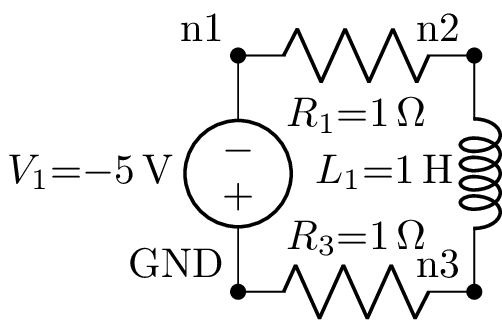

In [31]:
draw(name) #Run this cell only if drawing hints are provided in the netlist in the format mentioned earlier.

In [31]:
cktsolver(n, k, r, c, ll, v, cur, 0)

Look at the index number (below the graph) and modify it !  and change t1 too !


interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4), value=0), FloatSlider(value=10.0, des…

The voltage at node GND is [0.]
The voltage at node 1 is [-10.]
The voltage at node 2 is [-5.55555556]
The voltage at node 3 is [-3.7037037]
The current through voltage source 10.0 V between nodes (0, 1) is [-2.22222222]


### Range of Widgets :
- R values can range from $10^{-10}$ $\Omega$  to  $10^{8}$ $\Omega$
- C values can range from $10^{-10}$ $F$  to  $10^{8}$ $F$
- L values can range from $10^{-10}$ $H$  to  $10^{8}$ $H$
- V values can range from $10^{-3}$ V to $10^3$ V
- A values can range from $10^{-3}$ A to $10^3$ A

After changing the component values, do not forget to press the run interact option. This will register the changes made and will be reflected on the graph.

In [33]:
for res in r : #Used to change value of resistor dynamically
    print("Change the value of resistor between nodes "+str(res.nodes))
    lwr.append(widget(res.value))
for cap in c : #Used to change value of capacitor dynamically
    print("Change the value of capacitor between nodes "+str(cap.nodes))
    lwc.append(widget(cap.value))
    print("Enter initial charge on capacitor"+str(cap.nodes))
    lwccharge.append(widgetvi(cap.charge))
for ind in ll : #Used to change value of inductor dynamically
    print("Change the value of inductor between nodes "+str(ind.nodes))
    lwl.append(widget(ind.value))
    print("Enter initial current in inductor"+str(ind.nodes))
    lwlcurrent.append(widgetvi(ind.current))
for vol in v: #Used to change value of voltage source dynamically
    print("Change the value of voltage source between nodes "+str(vol.nodes))
    lwv.append(widgetvi(abs(vol.value)))
for curr in cur: #Used to change value of current source dynamically
    print("Change the value of current source between nodes "+str(curr.nodes))
    lwi.append(widgetvi(abs(curr.value)))
wdg.interact_manual(detectchange)

Change the value of resistor between nodes (1, 2)


interactive(children=(FloatSlider(value=1.0, description='x', max=100000000.0, min=1e-10, step=1e-10), Output(…

Change the value of resistor between nodes (3, 0)


interactive(children=(FloatSlider(value=1.0, description='x', max=100000000.0, min=1e-10, step=1e-10), Output(…

Change the value of inductor between nodes (2, 3)


interactive(children=(FloatSlider(value=1.0, description='x', max=100000000.0, min=1e-10, step=1e-10), Output(…

Enter initial current in inductor(2, 3)


interactive(children=(FloatSlider(value=0.0, description='x', max=1000.0, min=-1000.0, step=0.001), Output()),…

Change the value of voltage source between nodes (0, 1)


interactive(children=(FloatSlider(value=5.0, description='x', max=1000.0, min=-1000.0, step=0.001), Output()),…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<function __main__.detectchange()>

The below cell plots the function V(s) or I(s). This is important in many design applications in finding out the location of poles and zeroes in the complex s plane.

In [34]:
print("Again ! Select the node or voltage source and get the s domain plot of the same!!!")
wdg.interact(BodePlot, i= range(n+k)) #Plots Bode Plots 

Again ! Select the node or voltage source and get the s domain plot of the same!!!


interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_classes=('w…

<function __main__.BodePlot(i)>

In [35]:
reset()

### When to call reset () ?
Once you are done running each cell once, and want to load the next netlist. Run the reset() cell, this will clear all data corresponding to the current netlist and the program is ready to load the next netlist.

# Limitations
The limitations of the above Jupyter notebook model are - 
- The model assumes that sources are switched on or off at time t = 0. No other time is permitted. This is quite similar to LTSpice in a manner as in LTSpice, sources are permitted to start or stop at t = 0.
- If you change resistors or any other elements in the circuit, the transients would be regenerated from t=0 and not the previous stopping instant. 
- The run_interact button needs to be pressed to register the changes. This cannot be avoided in Jupyter notebook which otherwise could easily have been avoided in the web version by appropriate background web code.
- The option for wire has not been provided in the netlist. This will result in the circuit diagram not coming neatly in some cases. This can be added, but has not been added in this version since we were asked to deal with only R,L,C,V and I elements.

The solutions to the above are the use of Javascript to extract data dynamically from the user and generate graphs spontaneously. This is under the domain of Web Development and thus, is beyond the scope of a Python programming course. 

In order to make this project similar to the one on Falstad, we would need to integrate this python notebook with appropriate Javascript background, which is seemingly beyond the scope of this course. Notwithstanding that, this is the maximum interactivity offered by Jupyter notebooks. For further improvement in interactivity, a well written Javascript code must be integrated with this notebook to capture values dynamically.

All in all, this project could be considered as an alternate version of LTSpice and a precursor of Falstad.